# Projekt 3 - Sieci Neuronowe

### Przygotowanie danych

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import tarfile
from scipy import signal
import scipy
import librosa
from PIL import Image

Określenie klas, które dopuszczamy do klasyfikacji

In [2]:
valid_classes = "yes,no,up,down,left,right,on,off,stop,go".split(',')
dirs = os.listdir('./data')
dirs.remove('_background_noise_')
non_valid_classes = [x for x in dirs if x not in valid_classes]

Stworzenie ramki danych, która zawiera informacje o wszystkich plikach w zbiorze

In [3]:
dfrms = list()
for directory in dirs:
    files = os.listdir('./data/' + directory)
    cl = list(np.repeat(directory, len(files)))
    fullpath = ['./data/'+ c + '/' + file for c, file in zip(cl, files)]
    tmp = pd.DataFrame({'filename': files, 'fullpath': fullpath,'class': cl})
    dfrms.append(tmp)
df = pd.concat(dfrms)

In [4]:
len(valid_classes)

10

In [5]:
df.head()

,filename,fullpath,class
0,00176480_nohash_0.wav,./data/bed/00176480_nohash_0.wav,bed
1,004ae714_nohash_0.wav,./data/bed/004ae714_nohash_0.wav,bed
2,004ae714_nohash_1.wav,./data/bed/004ae714_nohash_1.wav,bed
3,00f0204f_nohash_0.wav,./data/bed/00f0204f_nohash_0.wav,bed
4,00f0204f_nohash_1.wav,./data/bed/00f0204f_nohash_1.wav,bed


In [6]:
# Podzial na train i test, ten sam speaker nie moze byc i tutaj i tutaj, wiec trzeba to jakos sensowanie podzielic
import copy
old = copy.deepcopy(df)

In [7]:
df = copy.deepcopy(old)

Dodanie kolumny identyfikującej speakera nagrania

In [8]:
filename = list(df['filename'])
speaker = [x.split('_')[0] for x in filename]
df = df.assign(speaker = speaker)
unq_speakers = np.unique(speaker)

Liczba unikalnych speakerów

In [9]:
unq_speakers.size

1881

Liczba wszystkich nagran

In [10]:
len(speaker)

64721

In [11]:
import random

def sample_fraction(seq, frac):
    return random.sample(seq, int(len(seq) * frac))

samp = sample_fraction(list(unq_speakers), 0.8)

In [12]:
df.head()

,filename,fullpath,class,speaker
0,00176480_nohash_0.wav,./data/bed/00176480_nohash_0.wav,bed,00176480
1,004ae714_nohash_0.wav,./data/bed/004ae714_nohash_0.wav,bed,004ae714
2,004ae714_nohash_1.wav,./data/bed/004ae714_nohash_1.wav,bed,004ae714
3,00f0204f_nohash_0.wav,./data/bed/00f0204f_nohash_0.wav,bed,00f0204f
4,00f0204f_nohash_1.wav,./data/bed/00f0204f_nohash_1.wav,bed,00f0204f


In [13]:
#df[df['speaker'].isin(samp)]

Zamiana niechcianych klas na klasę 'unknown'. Chwilowo wyrzucenie klas unknown dla przyspieszenia obliczeń.

In [14]:
# rename other classes
rows = df['class'].isin(non_valid_classes)
df.loc[rows ,'class'] = 'unknown'
df = df[df['class'] != 'unknown']

Rozkład ilosci probek z poszczegolnych klas

In [15]:
# Class distribution
classes_counts = {}
valid_classes
for cl in valid_classes: classes_counts[cl] = 0 
for cl in df['class']:
    classes_counts[cl] += 1

W miarę jednostajny rozkład wszystkich klas (valid)

In [16]:
classes_counts

{'yes': 2377,
 'no': 2375,
 'up': 2375,
 'down': 2359,
 'left': 2353,
 'right': 2367,
 'on': 2367,
 'off': 2357,
 'stop': 2380,
 'go': 2372}

Podział na zbiór testowy i treningowy

In [17]:
valid_classes

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [18]:
train = []
test = []
for cl in valid_classes:
    unq_speakers = np.unique(df.loc[df['class'] == cl , 'speaker'])
    train_samp = random.sample(range(unq_speakers.size), int(0.8 * unq_speakers.size))
    test_samp = [item for item in range(unq_speakers.size) if item not in train_samp]
    test.append(df.loc[df['class'] == cl].iloc[test_samp, :])
    train.append(df.loc[df['class'] == cl].iloc[train_samp, :])

In [19]:
train_df = pd.concat(train)
test_df = pd.concat(test)

In [20]:
train_df.size

38096

In [21]:
test_df.size / (test_df.size + train_df.size)

0.20033585222502098

Taraz mam podzielony zbiór w taki sposób, że 20% to testowy, 80% treningowy i w zbiorze testowym są inni speakerzy niż w treningowym.

In [22]:
train_df.head()

,filename,fullpath,class,speaker
538,3bc21161_nohash_4.wav,./data/yes/3bc21161_nohash_4.wav,yes,3bc21161
508,3903b558_nohash_0.wav,./data/yes/3903b558_nohash_0.wav,yes,3903b558
887,62ef962d_nohash_2.wav,./data/yes/62ef962d_nohash_2.wav,yes,62ef962d
276,210f3aa9_nohash_0.wav,./data/yes/210f3aa9_nohash_0.wav,yes,210f3aa9
1138,7ea032f3_nohash_2.wav,./data/yes/7ea032f3_nohash_2.wav,yes,7ea032f3


In [23]:
train_df.to_csv('train_df.csv', header=True, sep=";", index=False)
test_df.to_csv('test_df.csv', header=True, sep=";", index=False)

## Zapisywanie spektrogramów

Tworzenie drzewa folderow, zawierajacych spektrogramy.

In [ ]:
os.mkdir('./data_good')
os.mkdir('./data_good/train')
os.mkdir('./data_good/test')

for cl in valid_classes:
    os.mkdir('./data_good/train/' + cl)
    os.mkdir('./data_good/test/' + cl)

Funkcja maskująca szum:

In [ ]:
def envelope(y, rate, treshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate / 10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        mask.append(False) if mean < treshold else mask.append(True)
    return mask

Funkcja generująca pojedynczy spektrogram:

In [ ]:
#https://stackoverflow.com/questions/47147146/save-spectrogram-only-content-without-axes-or-anything-else-to-a-file-using-m
def create_spectrogram(filename, filepath, cl, targetdir):
    signal,rate = librosa.load(filepath, sr = 16000)
    mask = envelope(signal, rate, 0.005)
    fig,ax = plt.subplots(1, figsize = (0.25,0.25))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=signal[mask], Fs=rate, noverlap=500, NFFT=512)
    ax.axis('off')
    outputpath = './data_good/' + targetdir + '/' + cl + '/' + filename.split('.wav')[0] + '.jpg'
    fig.savefig(outputpath , dpi=300)
    fig.clear()
    plt.close(fig)
    return outputpath

Funkcja generująca cały dataset:

In [ ]:
def create_dataset(df, typeof, convert_grayscale = True):
    for index, row in df.iterrows():
            path = create_spectrogram(filename = row['filename'], filepath = row['fullpath'],
                                      cl = row['class'], targetdir = typeof)
            if convert_grayscale == True:
                img = Image.open(path).convert('L')
                img.save(path)

In [ ]:
#create_dataset(train_df, 'train')
#create_dataset(test_df, 'test')

## Dodatkowy zabieg do dataloadera

W celu wykonania własnego Dataset, koniecznym było wygenerowanie plików csv, które agregowałyby informacje o ścieżkach do plików oraz klasach komend. W tym celu został napisany poniższy kod, który generuje takie pliki.

In [31]:
import glob
import pandas as pd

path = '.\\data_good\\'

files = [f for f in glob.glob(path + "**/*.jpg", recursive=True)]

all_files = pd.DataFrame(files, columns = ['fullpath'])

In [ ]:
def correct_windows(line):
    line = list(line)
    for i, c in enumerate(line):
        if c == '\\':
            line[i] = '/'
    return ''.join(line)

In [32]:
def change_form(df):
    df.loc[:, 'fullpath'] = df.loc[:, 'fullpath'].apply(correct_windows)
    df['class'] = df.loc[:, 'fullpath'].apply(lambda path: path.split('/')[3])
    classes_unq = df.loc[:, 'class'].unique()
    d = dict([(x, i) for (i,x) in enumerate(classes_unq)])
    df["label"] = df.loc[:, 'class'].apply(lambda cl: d[cl])
    return df

In [33]:
def splitCsv(df_all):
    df_all = change_form(df_all)
    train = df_all[df_all.apply(lambda line: 'train' in line['fullpath'], axis = 1)]
    test = df_all[df_all.apply(lambda line: 'test' in line['fullpath'], axis = 1)]
    return train, test

In [35]:
train, test = splitCsv(all_files)

In [36]:
train.to_csv('train.csv', header=True, sep=";", index=False)
test.to_csv('test.csv', header=True, sep=";", index=False)

## Tworzenie archiwum


Spakowane dane wraz plikami csv są pakowane, a następnie umieszczene na AWS s3 w celu ich pobrania z poziomu Google Colab.

In [38]:
import tarfile

with tarfile.open('audioSpectrograms2.tar.gz', mode='w:gz') as archive:
    archive.add('./data_good/test', recursive=True)
    archive.add('./data_good/train', recursive=True)
    archive.add('train.csv')
    archive.add('test.csv')

## Przykład jak działa odszumianie

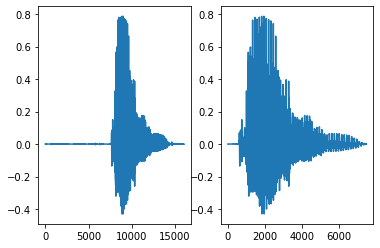

In [67]:
wav_file = 'path_to_file'
signal,rate = librosa.load(wav_file, sr = 16000)
mask = envelope(signal, rate, 0.005)

plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.plot(signal[mask])